Ignacio Vellido Expósito

In [1]:
import cv2

# Función para mostrar varias imágenes en una sola ventana
import numpy as np
from matplotlib import pyplot as plt

def plot_vector_img(vim, cols=0, titles=None, suptitle=None, gray=False):
    """ Visualiza varias imágenes a la vez """
    n_images = len(vim)

    if not cols:
        cols = 7 if len(vim) >= 7 else len(vim)

    if titles is None:
        titles = ['' for i in range(1, n_images+1)]

    if suptitle is None:
          suptitle = ''

    fig = plt.figure()
    for n, (image, title) in enumerate(zip(vim, titles)):
        a = fig.add_subplot(int(np.ceil(n_images/float(cols))), cols, n+1)          
        plt.imshow(image, "gray" if gray else None)        

        a.set_title(title)        
        a.axis('off')

    fig.suptitle(suptitle)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    fig.subplots_adjust(bottom=0)

    plt.show()

Utiliza el filtrado para buscar formas en una imagen.

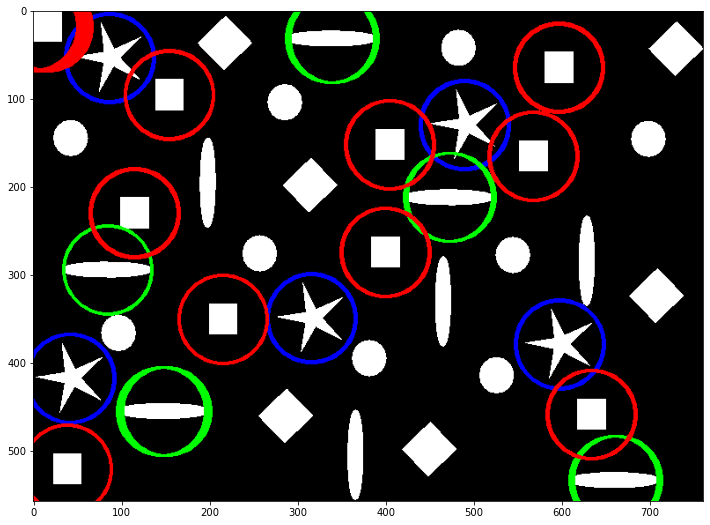

In [79]:
img = cv2.imread("formas.png")
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Al no estar en escala de grises lo pasamos a binario
img = cv2.threshold(img, 128, 1, cv2.THRESH_BINARY)[1]

# ------------

# Estrella
# Creamos un kernel con la imagen a buscar de un tamaño un poco más pequeño
kernel = cv2.imread("estrella.png", 0)
kernel = cv2.threshold(kernel, 128, 1, cv2.THRESH_BINARY)[1]
kernel = cv2.resize(kernel, (0,0), fx=0.8, fy=0.8)

# Aplicamos filtrado
pattern = cv2.filter2D(img, cv2.CV_16S, kernel)

# En aquellos puntos con la misma sumatoria de píxeles positivos está
# el objeto
for point in np.argwhere(pattern == kernel.sum()):
    rgb = cv2.circle(rgb, (point[1],point[0]), 50, (0,0,255), 2)

# ------------

# Óvalo
kernel = cv2.imread("ovalo.png", 0)
kernel = cv2.threshold(kernel, 128, 1, cv2.THRESH_BINARY)[1]
kernel = cv2.resize(kernel, (0,0), fx=0.93, fy=0.93)

pattern = cv2.filter2D(img, cv2.CV_16S, kernel)

for point in np.argwhere(pattern == kernel.sum()):
    rgb = cv2.circle(rgb, (point[1],point[0]), 50, (0,255,0), 2)

# ------------

# Cuadrado
kernel = cv2.imread("cuadrado.png", 0)
kernel = cv2.threshold(kernel, 128, 1, cv2.THRESH_BINARY)[1]
kernel = cv2.resize(kernel, (0,0), fx=0.95, fy=0.95)

pattern = cv2.filter2D(img, cv2.CV_16S, kernel)

for point in np.argwhere(pattern == kernel.sum()):
    rgb = cv2.circle(rgb, (point[1],point[0]), 50, (255,0,0), 2)

plt.figure(figsize=(12,12))
plt.imshow(rgb)

Compara el resultado que producen el filtrado gaussiano y el filtro de mediana sobre las imágenes disney_r1.png ... disney_r5.png

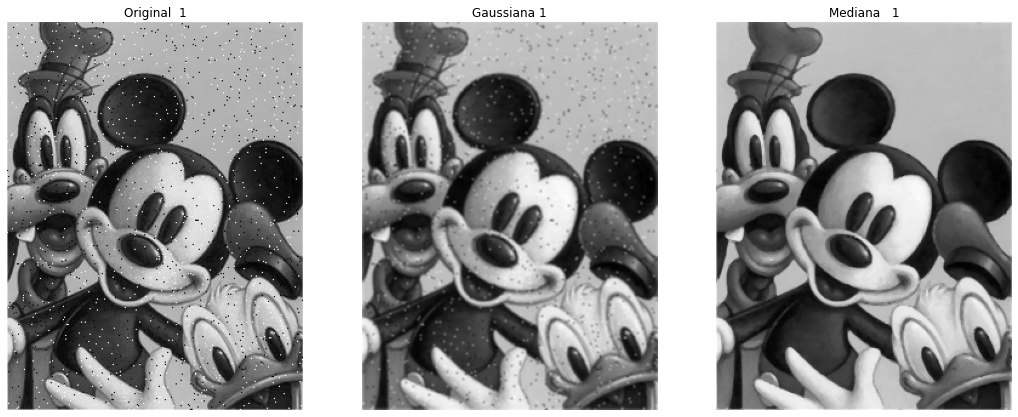

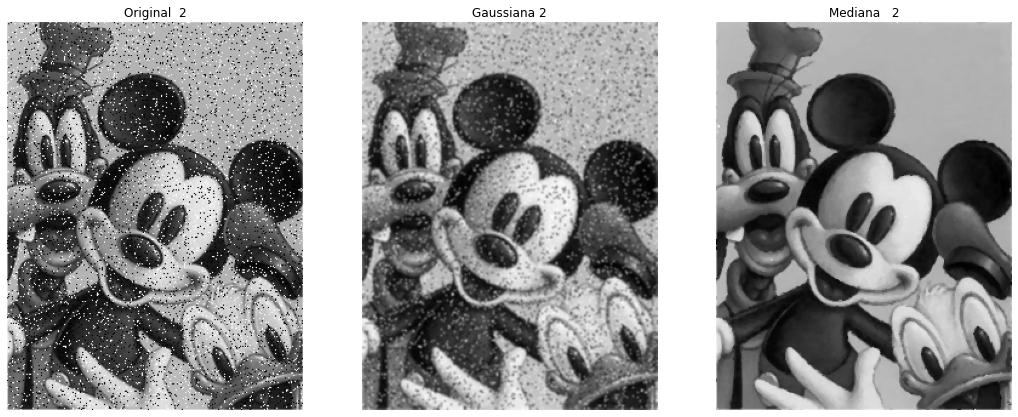

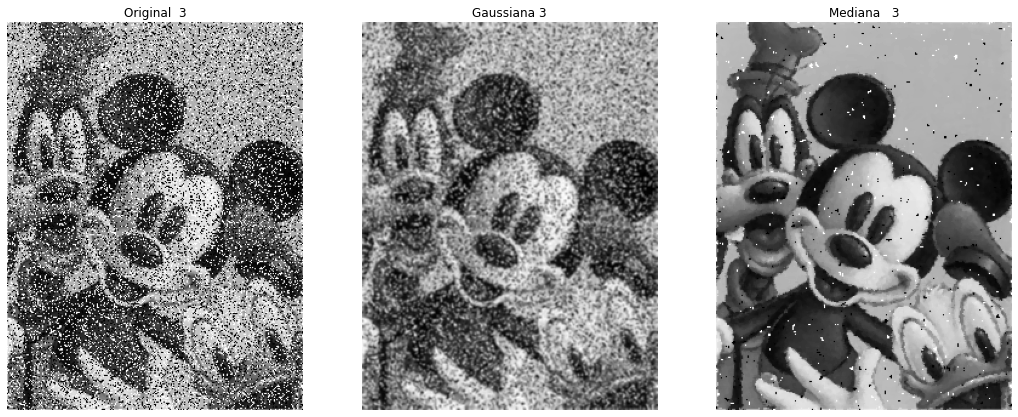

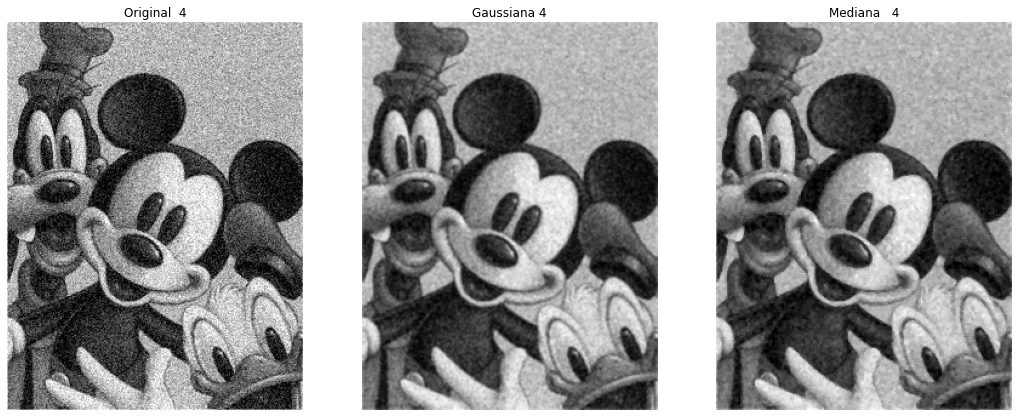

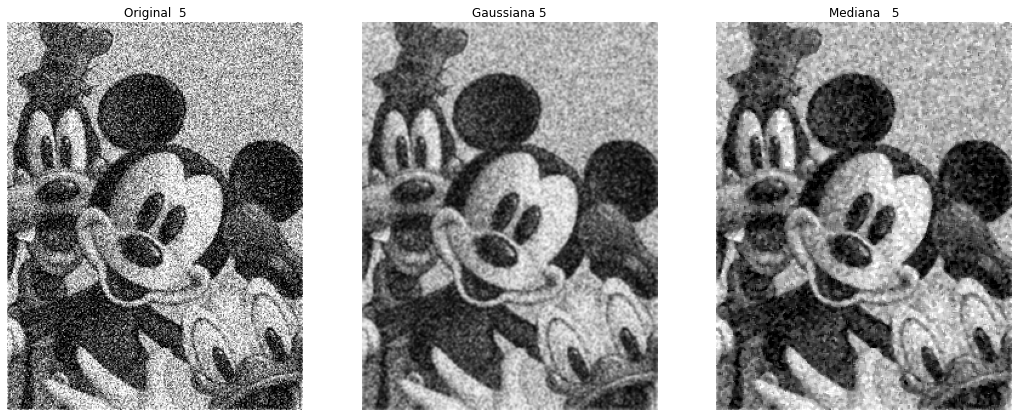

In [31]:
for i in range(1,6):
    img = cv2.imread("disney_r{}.png".format(i), 0)

    gau = cv2.GaussianBlur(img, (3,3), 0)
    med = cv2.medianBlur(img, 3)

    vim = [img, gau, med]
    titles = [
        "Original  {}".format(i),
        "Gaussiana {}".format(i),
        "Mediana   {}".format(i),
    ]
    plot_vector_img(vim, 3, titles, gray=True)

Analizar la imagen distorsion1.jpg y aplicar diferentes técnicas para mejorarla (eliminación del ruido). En concreto, prueba con suavizados gaussianos y con un suavizado bilateral.

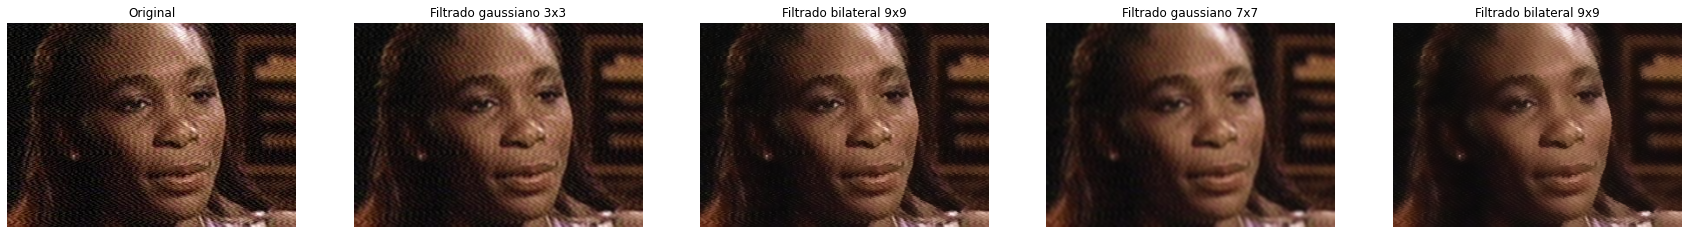

In [48]:
img = cv2.imread("distorsion1.jpg")
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Vemos ruido tipo tv en la imagen

gau3 = cv2.GaussianBlur(rgb, (3,3), 0)
bila9 = cv2.bilateralFilter(rgb, 9, 50, 75)

gau7 = cv2.GaussianBlur(rgb, (7,7), 0)
bila = cv2.bilateralFilter(rgb, 13, 75, 90)

# Mostrar imágenes
vim = [
    rgb,
    gau3,
    bila9,
    gau7,
    bila
]

titles = [
    "Original",
    "Filtrado gaussiano 3x3",
    "Filtrado bilateral 9x9",
    "Filtrado gaussiano 7x7",
    "Filtrado bilateral 13x13",
]

plot_vector_img(vim, titles=titles)

Obtener sobre la imagen formas.png las esquinas usando el método de Harris. Implementar el algoritmo de Moravec y aplicalo para obtener las esquinas de formas.png.

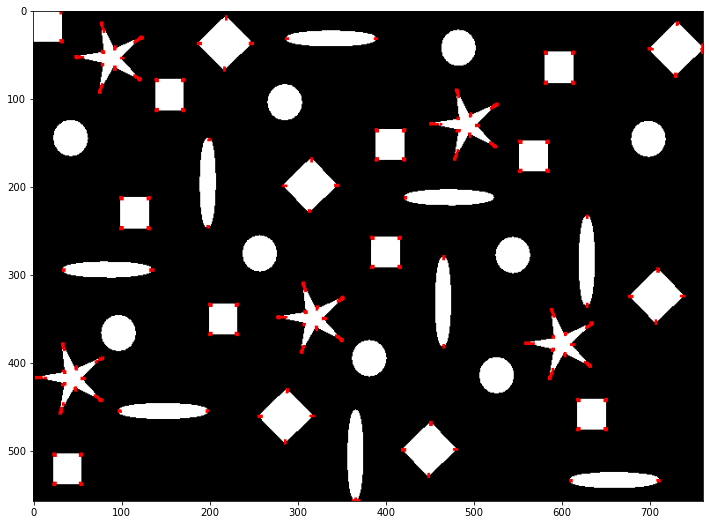

In [27]:
img = cv2.imread("formas.png")

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)

dst = cv2.cornerHarris(gray, blockSize=2, ksize=7, k=0.04)

# Dilatación y umbralización
dst = cv2.dilate(dst, None)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img[dst > 0.01*dst.max()] = [255,0,0]

plt.figure(figsize=(12,12))
plt.imshow(img)


In [2]:
def no_maximos(img, mask_size):
    res = np.zeros_like(img)
    mask = np.empty((mask_size,mask_size), dtype=img.dtype)

    # Creamos un border (Replicate, pues no altera el valor del máximo)
    img_border = cv2.copyMakeBorder(img, mask_size-2, mask_size-2, 
                                    mask_size-2, mask_size-2, cv2.BORDER_REFLECT)

    for i in range(0, len(img)):
        for j in range(0, len(img[0])):
            mask = img_border[i:i+mask_size, j:j+mask_size]

            # Comprobando si máximo local           
            is_local_max = True
            for v in range(0, mask_size):
                for w in range(0, mask_size):
                    if v != 1 or w != 1:
                        is_local_max = False if mask[v,w] >= mask[1,1] else is_local_max                    

            if is_local_max:
                res[i, j] = img_border[i+1, j+1]

    return res

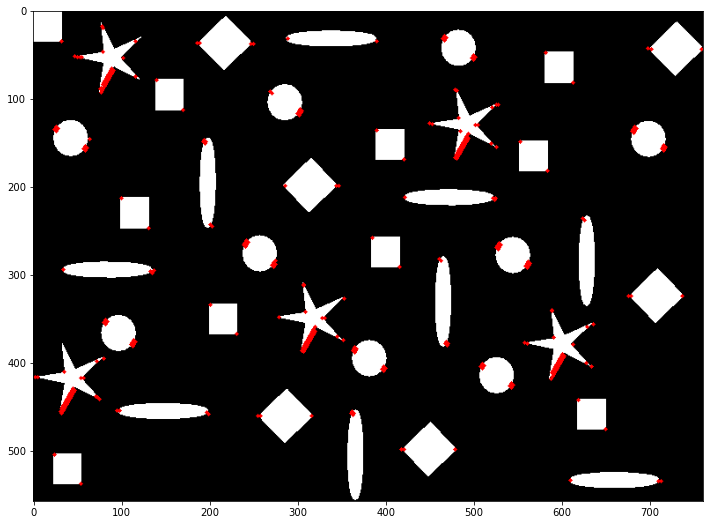

In [30]:
def apply_kernel_moravec(img, kernels):
    # Kernels brújula
    kernel_hh = kernels[0]
    kernel_vv = kernels[1]
    kernel_d1 = kernels[2]
    kernel_d2 = kernels[3]

    h = cv2.filter2D(img, -1, kernel_hh)
    v = cv2.filter2D(img, -1, kernel_vv)
    dia1 = cv2.filter2D(img, -1, kernel_d1)
    dia2 = cv2.filter2D(img, -1, kernel_d2)

    hh = np.empty_like(h)
    vv = np.empty_like(h)
    d1 = np.empty_like(h)
    d2 = np.empty_like(h)

    rows, cols = img.shape
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            hh[i,j] = np.sum(np.abs(h[i-1:i+1, j-1:j+1]))
            vv[i,j] = np.sum(np.abs(v[i-1:i+1, j-1:j+1]))
            d1[i,j] = np.sum(np.abs(dia1[i-1:i+1, j-1:j+1]))
            d2[i,j] = np.sum(np.abs(dia2[i-1:i+1, j-1:j+1]))

    c = np.minimum(hh, vv)
    c = np.minimum(c, d1)
    c = np.minimum(c, d2)

    return c

# -----------------------------------------------------------------

def moravec(img):
    kernel_hh = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    kernel_vv = kernel_hh.T
    kernel_d1 = np.array([[0,1,1],[-1,0,1],[-1,-1,0]])
    kernel_d2 = np.array([[-1,-1,0],[-1,0,1],[0,1,1]])

    kernels = [
        kernel_hh,
        kernel_vv,
        kernel_d1,
        kernel_d2
    ]

    c1 = apply_kernel_moravec(img, kernels)

    # Invertir la dirección de los kernels y repetir
    kernels = [
        kernel_hh * -1,
        kernel_vv * -1,
        kernel_d1 * -1,
        kernel_d2 * -1
    ]

    c2 = apply_kernel_moravec(img, kernels)
    
    # Hacer supresión de no-máximos
    res1 = no_maximos(c1, 3)
    res2 = no_maximos(c2, 3)

    res1 = np.argwhere(res1 != 0)
    res2 = np.argwhere(res2 != 0)
    res = np.append(res1,res2, axis=0)    

    return res

# -----------------------------------------------------------------

rgb = cv2.imread("formas.png")
img = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)

corners = moravec(img)

for point in corners:
    rgb = cv2.circle(rgb, (point[1],point[0]), 2, (255,0,0), -1)

plt.figure(figsize=(12,12))
plt.imshow(rgb)

Utiliza algunas de las operaciones morfológicas para buscar formas en una imagen. Como ayuda a este ejercicio pensad que el elemento estructural puede ser la imagen que queréis buscar. Para este ejercicio puedes usar las siguientes imágenes:

formas.png, estrella.png, ovalo.png, cuadrado.png, cuadrado2.png,cuadrado3.png

texto.png, letra_i.png, letra_k.png, letra_m.png, letra_o.png, letra_p.png

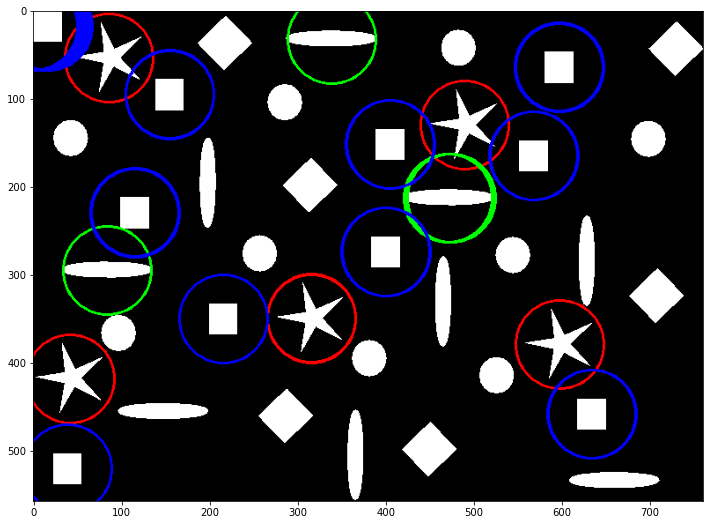

In [181]:
img = cv2.imread("formas.png")
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Estrella
kernel = cv2.imread("estrella.png", 0)
kernel = cv2.resize(kernel, (0,0), fx=0.8, fy=0.8)

pattern = cv2.erode(img, kernel, iterations = 1)

for point in np.argwhere(pattern > 0.01*pattern.max()):
    rgb = cv2.circle(rgb, (point[1],point[0]), 50, (255,0,0), 2)

# Óvalo
kernel = cv2.imread("ovalo.png", 0)
kernel = cv2.resize(kernel, (0,0), fx=0.9, fy=0.9)

pattern = cv2.erode(img, kernel, iterations = 1)

# Habría que elimiar puntos cercanos entre sí, nos interesaría solo uno
for point in np.argwhere(pattern > 0.01*pattern.max()):
    rgb = cv2.circle(rgb, (point[1],point[0]), 50, (0,255,0), 2)

# Cuadrado
kernel = cv2.imread("cuadrado.png", 0)
kernel = cv2.resize(kernel, (0,0), fx=0.93, fy=0.93)

pattern = cv2.erode(img, kernel, iterations = 1)

for point in np.argwhere(pattern > 0.01*pattern.max()):
    rgb = cv2.circle(rgb, (point[1],point[0]), 50, (0,0,255), 2)

plt.figure(figsize=(12,12))
plt.imshow(rgb)

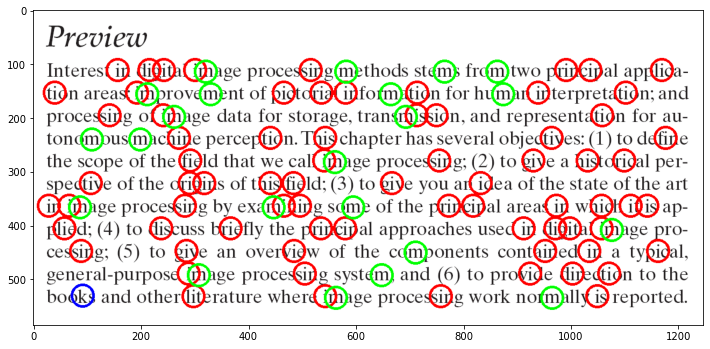

In [166]:
img = cv2.imread("texto.png")
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Hacemos el negativo por tener texto negro sobre fondo blanco
img = cv2.bitwise_not(img)

# Estrella
kernel = cv2.imread("letra_i.png", 0)
kernel = cv2.bitwise_not(kernel)
pattern = cv2.erode(img, kernel, iterations = 1)

for point in np.argwhere(pattern > 0.01*pattern.max()):
    rgb = cv2.circle(rgb, (point[1],point[0]), 20, (255,0,0), 3)

# Óvalo
kernel = cv2.imread("letra_m.png", 0)
kernel = cv2.bitwise_not(kernel)
pattern = cv2.erode(img, kernel, iterations = 1)

for point in np.argwhere(pattern > 0.01*pattern.max()):
    rgb = cv2.circle(rgb, (point[1],point[0]), 20, (0,255,0), 3)

# Cuadrado
kernel = cv2.imread("letra_k.png", 0)
kernel = cv2.bitwise_not(kernel)
pattern = cv2.erode(img, kernel, iterations = 1)

for point in np.argwhere(pattern > 0.01*pattern.max()):
    rgb = cv2.circle(rgb, (point[1],point[0]), 20, (0,0,255), 3)

plt.figure(figsize=(12,12))
plt.imshow(rgb)